# Dispersi Gelombang Love

Untuk mendapatkan nilai kecepatan semu pada dispersi gelombang Love kita dapat menggunakan persamaan:
$$\tan(\omega\zeta) = \left(\frac{\mu_2(1-c_z^2/\beta_2^2 )^{1/2}}{\mu_1}\right)\left(\frac{h}{c_z\zeta}\right),$$

dengan $\mu$ adalah modulus geser (kg/ms²), $\beta$ adalah kecepatan gelombang geser (m/s), $\rho$ adalah rapat massa (kg/cc), $h$ adalah ketebalan lapisan pertama (m), dan $C_x$ adalah nilai kecepatan yang divariasikan. Nilai kecepatan semu didapatkan dari titik potong suku di ruas kanan dan suku di ruas kiri, serta $\zeta$ didefinisikan sebagai:

$$\zeta = \left(\frac{h}{c_x}\right)\left(\frac{c_x^2}{\beta_1^2-1}\right)^{1/2}$$

Nilai kecepatan semu untuk setiap periode $T$ akan dicari kemudian diplot untuk melihat sifat dispersi dari gelombang Love.

Pada kasus ini kita akan mencari sifat dispersi untuk wilayah Yogyakarta, sifat fisis bawah permukaan untuk Yogyakarta adalah sebagai berikut:

In [103]:
beta1 = 750 #m/s
rho1 = 1500 #kg/cc
beta2 = 1500 #m/s
rho2 = 2500 #kg/cc
h=800 #m

## Pembuatan plot bawah permukaan
Sebelum melakukan penghitungan, kita terlebih dahulu akan membuat gambaran dari model bawah permukaan berdasarkan sifat-sifat fisis di atas.

In [104]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [105]:
def subsurface_model(rho1, rho2, beta1, beta2, h):
    
    # triangle infinity
    ty = np.ones(10)*2*h
    tx = np.linspace(0.69,1.30,10)

    fig = plt.figure()
    spec = gridspec.GridSpec(ncols=3, nrows=1,
                             width_ratios=[3, 1,1])

    ax0 = fig.add_subplot(spec[0])
    l1=ax0.bar([1],[h], color="#ff7f0e")
    l2=ax0.bar([1],[h], bottom=[h], color="#1f77b4")
    ax0.set_ylim(2*h+h/4,-0.2*h)
    ax0.scatter(tx,ty, marker="v", s=1000, color="#1f77b4")
    ax0.set_ylabel("depth (m)")
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.text(1,h/2,"Layer 1", horizontalalignment='center')
    ax0.text(1,h+h/2,"Layer 2", horizontalalignment='center', color="white")
    ax0.set_title("Subsurface Model")

    ax1 = fig.add_subplot(spec[1])
    yy=(0,h, 2*h+h/4)
    xx=(rho1,rho2, rho2)
    ax1.axvline(rho1+((rho2-rho1)/2), color='k', lw=.5)
    ax1.step(xx,yy,drawstyle='step-post', color='#1f77b4')
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.set_ylim(2*h+h/4,-0.2*h)
    ax1.set_xlim(rho1-200, rho2+200)
    ax1.set_xticks([rho1,rho2])
    ax1.set_xlabel(r"$ \rho $ (kg/cc)")
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')


    ax2 = fig.add_subplot(spec[2])
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.axvline(beta1+((beta2-beta1)/2), color='k', lw=.5)
    ax2.set_ylim(2*h+h/4,-0.2*h)
    xx2=(beta1,beta2, beta2)
    ax2.step(xx2,yy,drawstyle='step-post', color='#1f77b4')
    ax2.set_xlim(beta1-200, beta2+200)
    ax2.set_xticks([beta1,beta2])
    ax2.set_xlabel(r"$ \beta $ (m/s)")
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    plt.savefig("./love/model_{}-{}_{}-{}_{}.jpg".format(rho1,rho2,beta1,beta2,h), dpi=300)
    plt.show()

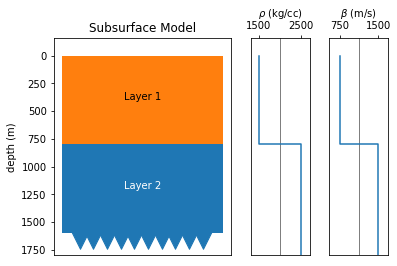

In [106]:
subsurface_model(rho1,rho2,beta1,beta2,h)

## Pembuatan fungsi-fungsi pendukung
Pembuatan algoritma penentuan kecepatan semu dan pembuatan kurva dispersi diawali dengan membuat fungsi-fungsi kecil untuk menghitung beberapa nilai turunan dari sifat-sifat fisis di atas, yaitu:

$$\mu = {\beta_1^2}\times{\rho}$$

$$\omega = \frac{2\pi}{T}$$

$$ C_x = \sqrt{\frac{\beta1^2\times h^2}{h^2 - \beta_1^2 \zeta^2}}$$

In [107]:
def mu(beta,rho):
    mu_v = (beta**2)*rho
    return mu_v

def w(T):
    w_v = 2 * math.pi / T
    return w_v

def zeta(h, cx, beta1):
    zeta_v= (h/cx)*math.sqrt((cx**2)/(beta1**2)-1)
    return zeta_v

def cx(beta1, h, zeta):
    cx_v = math.sqrt(((beta1**2)*(h**2))/((h**2)-((zeta**2)*(beta1**2))))
    return cx_v

## Pembuatan fungsi utama
Langkah selanjutnya adalah membuat fungsi untuk ruas kanan (`rhs`) dan ruas kiri (`lhs`) menggunakan nilai-nilai turunan dan fungsi yang sebelumnya sudah kita definisikan. Pada langkah ini kita juga membuat algoritma untuk menentukan titik potong dari nilai ruas kanan dan ruas kiri secara komputasi.

Pencarian titik potong dimulai dengan mencari nilai perbedaan ruas kanan dan kiri yang terendah, caranya adalah dengan mencari nilai minimum dari nilai absolut selisih ruas kanan dan ruas kiri. Dari nilai selisih tersebut kemudian dicari index dari selisih tersebut pada range nilai pertama sampai nilai sebelum mengalami diskontinuitas yang pertama. Index tersebut kemudian digunakan untuk mendapatkan nilai apparent velocity dari $C_x$.

In [108]:
def rhs(rho1,rho2,cx,beta2,beta1,h):
    mu1 = mu(beta1,rho1)
    mu2 = mu(beta2,rho2)
    top = mu2*math.sqrt(1-((cx**2)/(beta2**2)))
    bottom = mu1
    if zeta(h,cx,beta1) != 0:
        right = h/cx/zeta(h,cx,beta1)
        rhs_v = top/bottom*right
        return rhs_v
    else:
        return np.nan

def lhs(h, cx, beta1, T):
    zeta_v = zeta(h, cx, beta1)
    w_v = w(T)
    lhs_v = math.tan(w_v*zeta_v)
    return lhs_v

def apparent_vel(cxs, lhs_arr, rhs_arr,h,beta1,T):
    difs = []
    for i,v in enumerate(lhs_arr):
        difs.append(abs(lhs_arr[i]-rhs_arr[i]))
    difs_break_nan = []
    for c,k in enumerate(difs): #can be modified for multimodal
        if c == 0:
            pass
        else:
            if str(k) == "nan":
                break
            difs_break_nan.append(k)
    if len(difs_break_nan) >0:
        app_vel_v_index = min(difs_break_nan)
        min_difs_indexes = np.where(difs == app_vel_v_index)
        if len(min_difs_indexes) > 1:
            min_difs_index = min_difs_indexes[0] #can be modified for multimodal
        else:
            min_difs_index = min_difs_indexes[0]
        app_vel_v = cxs[min_difs_index]
        lhs_v = lhs(h, app_vel_v[0], beta1, T)
        return app_vel_v[0],lhs_v
    else:
        return np.nan, np.nan

## Penggambaran perpotongan fungsi
Pengeplotan perlu beberapa trik karena adanya diskontinuitas pada ruas kiri yang merupakan fungsi $tan(\omega\zeta)$,untuk menangani hal ini yang perlu dilakukan adalah dengan mengisi nilai ruas kiri dengan nilai `np.nan` apabila ditemukan selisih antar nilai sekarang dan nilai sebelumnya bernilai negatif, yang seharusnya fungsi tan seharusnya memiliki gradien positif.

In [109]:
def love_dispersion_equation(rho1,rho2,beta1,beta2,h,T,npts=1000,plot=True):
    cxs = np.linspace(beta1,beta2,npts)
    zetas = []
    lhss = []
    rhss = []
    lhss_no_nan = []
    for i,cx in enumerate(cxs):
        ZETA = zeta(h, cx, beta1)
        RHS = rhs(rho1,rho2,cx,beta2,beta1,h)
        LHS=lhs(h, cx, beta1, T)

        rhss.append(RHS)
        zetas.append(ZETA)
        if i>0:
            if (LHS-lhss_no_nan[-1]) > 0:
                lhss.append(LHS)
                lhss_no_nan.append(LHS)
            else:
                lhss.append(np.nan)
                lhss_no_nan.append(LHS)
        else:
            lhss.append(LHS)
            lhss_no_nan.append(LHS)

    apv = apparent_vel(cxs, lhss, rhss, h, beta1, T)
    
    if plot:
        fig, ax1 = plt.subplots() 

        ax1.plot(zetas,rhss,linestyle="--", label="RHS")
        ax1.plot(zetas,lhss, label="LHS")
        ax1.axvline(zeta(h,apv[0],beta1), linestyle="--", color='k', alpha=.5)
        ax1.scatter(zeta(h,apv[0],beta1),apv[1], color="r", label="$n_0$")
        ax1.set_xlim(zetas[0], zetas[-1])
        rhss_no_nan = [f for f in rhss if str(f) != "nan"]
        ax1.set_ylim(-max(rhss_no_nan),max(rhss_no_nan))
        ax1.text(zeta(h,apv[0],beta1), -.8*(max(rhss_no_nan)), 
                 "$\zeta$ = {:04.2f} | $C_x$ = {:06.2f}".format(zeta(h,apv[0],beta1),apv[0]), 
                 horizontalalignment='center',  
                 bbox=dict(facecolor='white', alpha=1))
        ax1.grid(True)
        ax1.set_xlabel("$\zeta$")
        plt.legend()
        plt.savefig("./love/jogja_{}s.jpg".format(T), dpi=300)
        plt.title("T={} s".format(T))
    return apv[0]


Untuk kasus Yogyakarta dengan menggunakan jumlah titik perhitungan adalah 1000 dengan nilai periode 1,5 sekon hasilnya adalah:

796.5465465465466

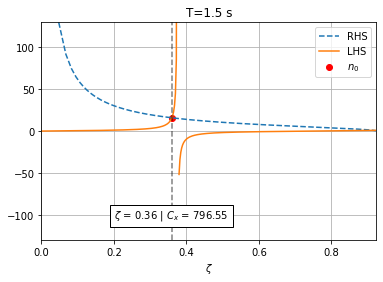

In [110]:
love_dispersion_equation(rho1,rho2,beta1,beta2,h,1.5,1000,plot=True)

Pencarian titik potong menggunakan fungsi di atas sangat tergantung dari jumlah titik yang digunakan dalam kalkulasi (`npts`). Dalam hal ini karena nilai selisih ruas kiri dan ruas kanan tidak dibatasi nilainya, maka berapapun selisihnya asal yang paling kecil maka itulah yang dianggap sebagai nilai kecepatan semu, walaupun dalam grafiknya tidak berpotongan. Contohnya adalah apabila menggunakan nilai `npts` sebesar 40:

788.4615384615385

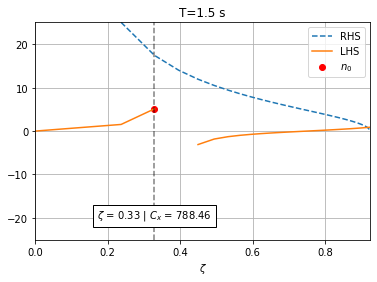

In [111]:
love_dispersion_equation(rho1,rho2,beta1,beta2,h,1.5,40,plot=True)

Pada contoh di atas sangat terlihat bahwa grafik tidak berpotongan tetapi nilai tetap diambil, kasus ini sengaja ditampilkan sebagai *debugging* dari fungsi tersebut. Apabila akan digunakan dalam sebuah aplikasi yang digunakan untuk produksi maka nilai selisih seharusnya dibatasi sampai nilai yang kecil yang menggambarkan kondisi kurva yang berpotongan.

## Penggambaran kurva dispersi

Menggunakan fungsi yang sudah dibuat untuk mencari nilai titik potong maka dengan menggunakan *looping* sederhana untuk setiap nilai periode maka kita bisa mendapatkan nilai kecepatan semu dari masing-masing periode tersebut. Fungsi yang digunakan seperti di bawah ini.

In [112]:
def love_wave_dispersion(rho1,rho2,beta1,beta2,h,Ts,npts=1000,test_arr=False):
    app_vel_plot = []
    for T in Ts:
        apv = love_dispersion_equation(rho1,rho2,beta1,beta2,h,T,npts,plot=False)
        app_vel_plot.append(apv)

    plt.scatter(Ts,app_vel_plot)
    plt.plot(Ts,app_vel_plot)
    #plt.title("Dispersion Curve for $\beta_1$={}, $\beta_2$={}, $\rho_1$={}, $\rho_2$={}, $h$={}".format(beta1,beta2,rho1,rho2,h))
    plt.title("Love Wave Dispersion Curve of Yogyakarta")
    plt.xlabel("Period (s)")
    plt.ylabel("Apparent velocity (m/s)")
    plt.grid(True)
    plt.text(Ts[-1],app_vel_plot[0],
             """rho_1 = {} \n 
             rho_2 = {} \n
             beta_1 = {} \n
             beta_2 = {} \n
             h = {}""".format(rho1,rho2,beta1,beta2,h), 
             horizontalalignment="right", verticalalignment="bottom", 
             bbox=dict(facecolor='white', alpha=.5))
    if test_arr:
        for i in test_arr:
            plt.axvline(x=i, linestyle="--", color="k", alpha=0.5)
    plt.savefig("./love/jogja_dispersion_all.jpg", dpi=300)



Dengan memvariasikan nilai periode ($T$) dari 1 sampai 20 dengan lompatan 0,5 serta menggunakan jumlah titik yang banyak yaitu 2000 kita dapat melihat sifat dispersif gelombang Love dalam kasus di Yogyakarta.

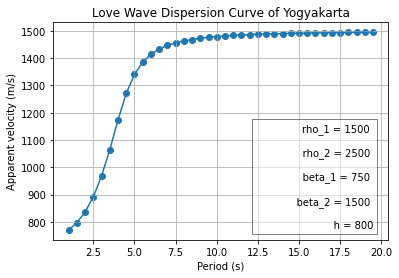

In [113]:
Ts = np.arange(1,20,.5)
love_wave_dispersion(rho1,rho2,beta1,beta2,h,Ts,2000)

Gelombang yang cepat didominasi oleh periode tinggi atau frekuensi rendah, sedangkan gelombang-gelombang frekuensi tinggi lebih lambat dan tertinggal. Sifat demikian yang kemudian digunakan dalam investigasi struktur bawah permukaan berdasarkan nilai dari kecepatan gelombang geser.

Sama seperti pada kasus pencarian nilai perpotongan, apabila jumlah titik yang digunakan dalam perhitungan terlalu kecil maka kurva dispersi akan memberikan nilai yang tidak tepat. Pada kurva dispersi apabila jumlah titik terlalu kecil maka akan muncul grafik yang bergerigi, seperti pada kasus di bawah ini dengan nilai `npts` adalah 40:

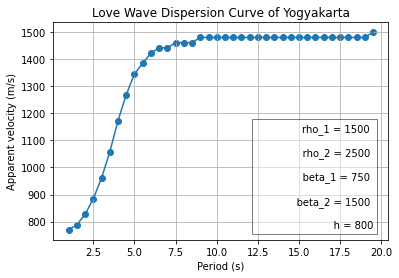

In [114]:
love_wave_dispersion(rho1,rho2,beta1,beta2,h,Ts,40)

## Lampiran

### Pengetesan

Pengetesan dilakukan menggunakan grafik dan parameter yang ada dalam buku An Introduction to Seismology, Earthquakes, and Earth Structure karya Seth Stein dan Michael Wysession. Parameternya adalah:



In [115]:
beta1_t = 3900 #m/s
rho1_t = 2800 #kg/cc
beta2_t = 4600 #m/s
rho2_t = 3300 #kg/cc
h_t=40000 #m

3924.512256128064

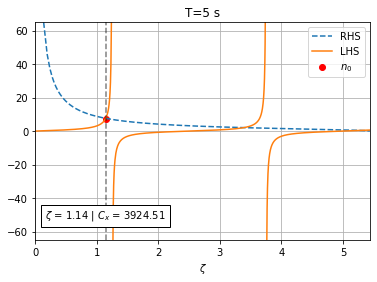

In [116]:
love_dispersion_equation(rho1_t,rho2_t,beta1_t,beta2_t,h_t,5,2000,plot=True)

3984.392196098049

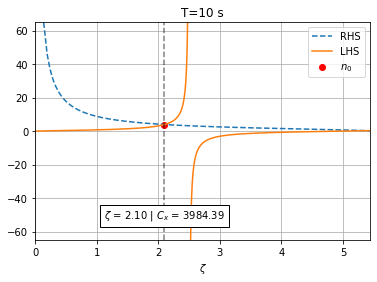

In [117]:
love_dispersion_equation(rho1_t,rho2_t,beta1_t,beta2_t,h_t,10,2000,plot=True)

4297.098549274638

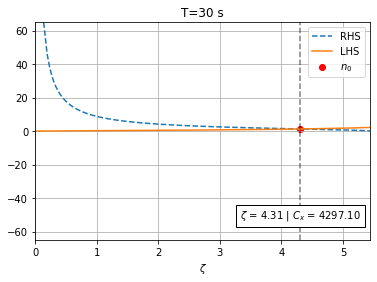

In [118]:
love_dispersion_equation(rho1_t,rho2_t,beta1_t,beta2_t,h_t,30,2000,plot=True)

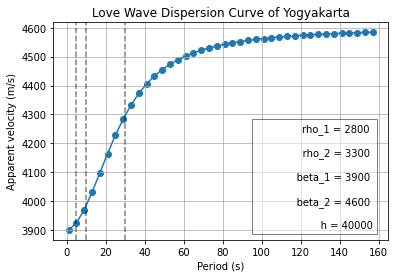

In [119]:
Ts_t = np.arange(1,160,4)
love_wave_dispersion(rho1_t,rho2_t,beta1_t,beta2_t,h_t,Ts_t,2000,(5,10,30))

### Flowchart umum
Flowchart sederhana dalam pencarian titik potong ruas kanan dan ruas kiri:
![flowchart](./love/umum_love.jpg)